
# Practical Bayesian Inference

### Kavli Summer Program in Astrophysics

- Bayes Introduction / Review
- Why is this hard?
- Method 1: Exact
- Method 2: Laplace
- Method 3: Markov-Chain Monte Carlo
- Method 4: Variational Inference

### UC Santa Cruz / July 2019

#### David Kirkby dkirkby@uci.edu

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd
import scipy.stats

## Bayes Introduction / Review

- Bayes rule
 - fundamental property of prob. theory, non-controversial.
 - issue is what constitutes a valid "prob".

- What is a probability?
 - frequentist: measures likelihood of different outcomes of an uncertain but infinitely repeatable process.
 - e.g. given a coin, can estimate its prob of H vs T using large number of trials.
 - Q: how might you assign a frequentist probability to the statement: "The age of the solar system is > 4 Gyr".
 - Bayesian: probs can also be assigned to outcomes whose frequencies cannot be measured, thus requiring some subjective input.
 - roughly speaking choice is between:
   - objective probabilities of uninteresting statements.
   - subjective probabilities of interesting statements.
 
- Terminology
 - conditional, joint, marginal
 - likelihood, prior, evidence, posterior
 - observables=features=data, parameters=latent, hyperparameters

- Exercise: England t-shirt?

- Bayes as updating rule: diagram, learn function.

- Exercise: estimate binomial prob with N=1000, N=1.
  - Suppose each observation is $$ (much early progress due to people solving practical problems, not academia: link to book).
  
- Practical advice.

## The Challenge

Most Bayesian inference problems cannot be solved exactly, so require an approximate method. The MCMC method is one such method, invented in the 1950s. **Variational inference (VI)** is an alternative approximate method, invented in the 1990s:
 - MCMC: provides an approximate description of the exact posterior distribution (using sampling).
 - VI: provides an exact description of an approximate posterior distribution (using optimization).

The underlying assumptions and numerical algorithms involved (sampling and optimization) are fundamentally different, leading to different tradeoffs between these methods.

## Method 1: Exact Marginalization: Discrete Problems and Conjugate Priors

## Method 2: Laplace Method

## Method 3: Markov-Chain Monte Carlo

### Markov-Chain Formalism

A **stochastic process** is a black-box generator of random sequences
$$
x_0, x_1, x_2, \ldots
$$

In general, the value $x_n$ depends on the history of all previous samples, so the black box has long-term memory.

A **Markov chain** is a special case where $x_n$ only depends *directly* on $x_{n-1}$: a black box with very short-term memory.

A **stationary** Markov chain uses the same rule $P(X_n\mid X_{n-1})$ to generate $x_n$ from $x_{n-1}$ for all $n$, i.e., it has no sense of time ($n$).

In practice, a stationary Markov chain is fully specified by two rules, which can be summarized with probabilities:
 - $P(X_0)$: generate an initial value $x_0$.
 - $P(X_n\mid X_{n-1})$: Generate the next value $x_n$ from the previous value $x_{n-1}$.

A **reversible** Markov chain has the same rule going in either direction, $P(X_n\mid P_{n-1}) = P(X_{n-1}\mid P_n)$. A reversible MC is always stationary but not vice versa.

### Markov-Chain Equlibrium

A Markov chain governed by $P(X_0)$ and $P(X_n\mid X_{n-1})$ **eventually** samples from **some** equilibrium distribution, $\tilde{P}(X)$.

This is not obvious, so a practical demonstration is useful...

In [77]:
class StochasticProcess(object):
    """Base class for a stochastic process.
    A subclass must implement the :meth:`initial` and :meth:`update` methods.
    """
    def __init__(self, seed=123):
        """Initialize a generic stochastic process.
        Parameters
        ----------
        seed : int or None
            Random seed to use for reproducible random numbers. A random state
            initialized with this seed is passed to the initial() and update()
            methods.
        """
        self.gen = np.random.RandomState(seed=seed)

    '''
    def plot(self, nsamples_per_run=50, nruns=3, joined=True):
        """Plot a few sequences of many samples.
        Parameters
        ----------
        nsamples_per_run : int
            Number of samples to plot for each run of the process.
        nruns : int
            Number of independent runs to plot. Should usually be a small
            number.
        joined : bool
            Join samples from the same run with lines when True.
        """
        cmap = sns.color_palette().as_hex()
        for i in range(nruns):
            run = self.run(nsamples_per_run)
            plt.plot(run, '.', c=cmap[i % len(cmap)])
            if joined:
                plt.plot(run, '-', alpha=0.2, c=cmap[i])
        plt.xlabel('Sequence number $n$')
        plt.ylabel('Value $x_n$')

    def pairplot(self, nsamples_per_run=4, nruns=500, x0cut=None):
        """Plot 1D and 2D statistics of a few samples using many runs.
        Uses a seaborn PairGrid.
        Parameters
        ----------
        nsamples_per_run : int
            Number of samples to include in the plot. Should usually be
            a small number.
        nruns : int
            Number of independent runs to use for building up statistics.
        x0cut : float or None
            Each plot is color-coded according to whether x0 is below or
            above this cut value, in order to show how dependencies propagate
            to later samples. Uses the median x0 value when None.
        """
        X = np.empty((nruns, nsamples_per_run))
        for i in range(nruns):
            X[i] = self.run(nsamples_per_run)
        names = ('$x_{{{}}}$'.format(j) for j in range(nsamples_per_run))
        df = pd.DataFrame(X, columns=names)
        # Color samples based on whether x0 > x0cut.
        x0 = X[:, 0]
        if x0cut is None:
            x0cut = np.median(x0)
        df['sel0'] = pd.cut(x0, [np.min(x0), x0cut, np.max(x0)])
        grid = sns.PairGrid(df, hue='sel0')
        grid.map_diag(plt.hist, histtype='stepfilled', alpha=0.4, lw=0)
        grid.map_diag(plt.hist, histtype='step', lw=2)
        grid.map_lower(plt.scatter, edgecolor='w', lw=0.5, s=20)
    '''
    def tabulate_conditional(self, n, m, lo, hi, nbins, nruns):
        """Tabulate the conditional probability P(Xm|Xn) numerically.
        n : int
            Tabulated probabilities are conditioned on n >= 0.
        m : int
            Tabulated probabilities are for P(Xm|Xn) with m > m.
        lo : float
            Tabulate values of Xn and Xm on the interval [lo, hi].
        hi : float
            Tabulate values of Xn and Xm on the interval [lo, hi].
        nbins : int
            Number of bins to use for tabulated values in [lo, hi].
        nruns : int
            Number of independent runs to perform to tabulate statistics.
        Returns
        -------
        tuple
            Tuple (bins, P) where bins is an array of nbins+1 bin edge values
            spanning [lo, hi] and P is an array of shape (nbins, nbins)
            containing the tabulated probabilities.  P is normalized for
            each value of the conditional Xn, i.e., P.sum(axis=1) = 1.
        """
        assert m > n and n >= 0
        nsteps = m - n
        result = np.empty((nbins, nbins))
        bins = np.linspace(lo, hi, nbins + 1)
        centers = 0.5 * (bins[1:] + bins[:-1])
        for i, Xi in enumerate(centers):
            Xj = []
            for j in range(nruns):
                history = [Xi]
                for k in range(nsteps):
                    history.append(self.update(history, self.gen))
                Xj.append(history[-1])
            result[i], _ = np.histogram(Xj, bins, density=True)
        result *= (hi - lo) / nbins
        assert np.allclose(result.sum(axis=1), 1)
        return bins, result

    def plot_conditional(self, bins, table, xlabel=None, ylabel=None,
                         show_mean=False, ax=None):
        """Plot a single tabulated conditional probability P(Xm|Xn).
        Parameters
        ----------
        bins : numpy array
            An array of nbins+1 bin edge values where conditional
            probabilities are tabulated in table. Usually obtained using
            :meth:`tabulate_conditional`.
        table : numy array
            An array of tabulated conditional probalities.
            Usually obtained using :meth:`tabulate_conditional`.
        xlabel : str or None
            Label to use for the variable Xm in P(Xm|Xn).
        ylabel : str or None
            Label to use for the variable Xn in P(Xm|Xn).
        show_mean : bool
            Calculate and plot the mean <Xm> under P(Xm|Xn) for each Xn.
        ax : matplotlib axis or None
            Use the specified axes for drawing or the current axes.
        """
        lo, hi = bins[0], bins[-1]
        if ax is None:
            ax = plt.gca()
        ax.imshow(table, interpolation='none', origin='lower',
                  extent=[lo, hi, lo, hi])
        if show_mean:
            xy = 0.5 * (bins[1:] + bins[:-1])
            mean = np.sum(xy * table, axis=1) / np.sum(table, axis=1)
            ax.plot(mean, xy , 'b-')
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.grid(False)

    def plot_conditionals(self, lo=0., hi=1., nbins=50, nruns=2000,
                          which=(1, 2, 3)):
        """Plot one or more sequential conditional probabilities.
        The initial probability P(X1|X0) is calculated using
        :meth:`tabulate_conditional` and each probability is plotted using
        :meth:`plot_conditional`. P(Xn|X0) is calculated as P(X1|X0) ** n.
        Parameters
        ----------
        lo : float
            Tabulate values of Xn and Xm on the interval [lo, hi].
        hi : float
            Tabulate values of Xn and Xm on the interval [lo, hi].
        nbins : int
            Number of bins to use for tabulated values in [lo, hi].
        nruns : int
            Number of independent runs to perform to tabulate statistics.
        which : iterable or ints
            Which conditional(s) to plot.
        """
        bins, T0 = self.tabulate_conditional(0, 1, lo, hi, nbins, nruns)
        T = T0.copy()
        if isinstance(which, int):
            which = (which,)
        n = len(which)
        fig, ax = plt.subplots(
            1, n, sharex=True, sharey=True, figsize=(4.2 * n, 4), squeeze=False)
        ylabel = '$X_0$'
        idx = 0
        for i in range(1, max(which) + 1):
            if i in which:
                xlabel = '$X_{{{}}}$'.format(i)
                self.plot_conditional(bins, T, xlabel, ylabel, ax=ax[0, idx])
                idx += 1
            T = T.dot(T0)
        plt.subplots_adjust(wspace=0.1)

    def run(self, nsamples_per_run):
        """Perform a single run of the stochastic process.
        Calls :meth:`initial` to get the initial value then calls
        :meth:`update` `nsamples_per_run-1` times to complete the run.
        Parameters
        ----------
        nsamples_per_run : int
            Number of samples to generate in this run, including the
            initial value.
        Returns
        -------
        numpy array
            1D array of generated values, of length `nsamples_per_run`.
        """
        history = [ self.initial(self.gen) ]
        for i in range(nsamples_per_run - 1):
            history.append(self.update(history, self.gen))
        return np.array(history)

    def initial(self, gen):
        """Return the initial value to use for a run.
        Parameters
        ----------
        gen : numpy.RandomState
            Use this object to generate any random numbers, for reproducibility.
        Returns
        -------
        float
            The initial value to use.
        """
        raise NotImplementedError

    def update(self, history, gen):
        """Return the next value to update a run.
        Parameters
        ----------
        history : list
            List of values generated so far.  Will always include at least
            one element (the initial value).
        gen : numpy.RandomState
            Use this object to generate any random numbers, for reproducibility.
        Returns
        -------
        float
            The next value to use.
        """
        raise NotImplementedError

Define a stationary Markov chain with the following rules:
 - $P(X_0)$: The initial value is chosen uniformly between 0 and 1.
 - $P(X_n\mid X_{n-1})$: The next value is sampled from
 $$
\bigl|
\mod(\cos(2\pi x_{n-1}) + 0.1 \epsilon, 1)
\;\bigr|
 $$
 where $\epsilon$ is a Gaussian random number.

In [78]:
class StationaryMarkovExample(StochasticProcess):

    def initial(self, gen):
        return gen.uniform()
    
    def update(self, history, gen):
        return np.abs(np.fmod(np.cos(2 * np.pi * history[-1]) +
                              0.1 * gen.normal(), 1))

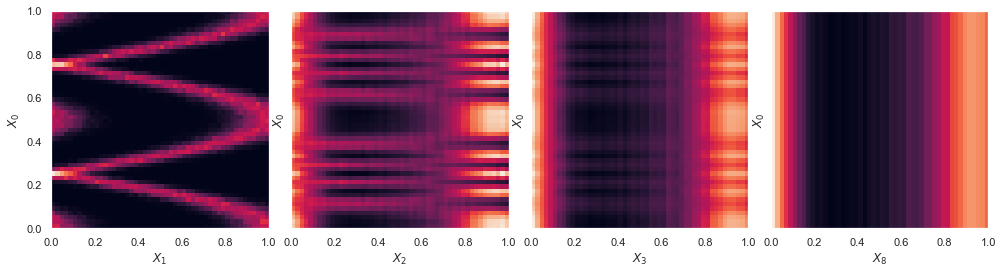

In [79]:
StationaryMarkovExample().plot_conditionals(which=(1, 2, 3, 8))

 - The left panel shows the update rule $P(X_n\mid X_{n-1})$ (but not the initial rule).
 - After 8 steps, the chain output $x_8$ has effectively forgotten about its initial value $x_0$: this is what we mean by "reaching equilibrium".
 - The density of $X_8$ in the right panel shows the equilibrium distribution $\tilde{P}(X)$.
 - What is the visual signature of reversibility in these plots? Is this a reversible chain?

For practical applications, there are two issues to deal with:
 - There is no way to know in advance how big $n$ needs to be to achieve equilibrium.
 - Given some stationary Markov chain, we can generate samples from *some* equilibrium distribution $\tilde{P}(X)$, but how do we build a chain to sample a specific distribution?

The second issue requires solving an [inverse problem](https://en.wikipedia.org/wiki/Inverse_problem), which is generally challenging.

However, there is a general family of methods to build a Markov chain with a desired probability density:

 - Metropolis-Hastings-Green
   - Metropolis-Hastings
     - Metropolis
     - Gibbs
     - Hamiltonian
     
MHG is the most general, but the simpler Metropolis-Hastings (MH) algorithm contains the essential ideas so we will focus on that.

### Metropolis-Hastings Updates

The MH algorithm relies on a **proposal distribution** $Q$ that is easier to sample than $\tilde{P}$.

(If you knew how to sample $\tilde{P}$ directly, you would not need MCMC!)

We often use a multivariate Gaussian for $Q$ since it is easy (and efficient) to sample from. Any proposal distribution is valid, but choosing a $Q$ "closer" to $\tilde{P}$ generally reaches the desired equilibrium faster.

The proposal distribution can either be used to update to the current state ("random walk"):
$$
X_{n+1} - X_n \sim Q
$$
or else to generate a new independent state each time:
$$
X_{n+1} \sim Q \; .
$$

During each update we evaluate a proposed move to $x_{n+1}$ by calculating the **Hastings ratio**,
$$
r(x_{n+1}, x_n) \equiv \frac{\tilde{P}(x_{n+1})}{\tilde{P}(x_n)}\, \frac{Q(x_n\mid x_{n+1})}{Q(x_{n+1}\mid x_n)} \; ,
$$
where $\tilde{P}$ is the desired equilibrium distribution.

Since $\tilde{P}$ only appears in a ratio, it does not need to be normalized: **this feature is why MCMC is useful for practical Bayesian inference.**

MCMC still requires that you can calculate un-normalized values of $\tilde{P}(x)$.

In general, the Hastings ratio is $\ge 0$ but it can otherwise be arbitrarily large.

We always accept a proposed move when $r(x_{n+1}, x_n) \ge 1$.  Otherwise, we accept it with a probability of $0\le r(x_{n+1}, x_n) < 1$.

When a proposed move is rejected, the update returns the original value, so **repetitions of the same output will occur**.

Generate samples in 2D using a Gaussian with zero mean and unit variance for the proposal distribution $Q$:

In [81]:
class MetropolisHastings(StochasticProcess):

    def __init__(self, Qrms, logP, ndim=2):
        super().__init__()
        self.logP = logP
        self.ndim = ndim
        self.Q = scipy.stats.multivariate_normal(
            mean=np.zeros(ndim), cov=np.diag(Qrms ** 2 * np.ones(ndim)))
    
    def initial(self, gen):
        return np.zeros(self.ndim)
    
    def update(self, history, gen):
        x_last = history[-1]
        # Sample the proposal distribution Q.
        x_proposed = x_last + self.Q.rvs(random_state=gen)
        # Calculate the Hastings ratio.
        ratio = np.exp(self.logP(x_proposed) - self.logP(x_last))
        # Accept x_proposed or keep x_last?
        return x_proposed if gen.uniform() < ratio else x_last

For our target distribution $\tilde{P}$, use a density that is flat inside a square:

In [70]:
def logP(x):
    return 1. if np.max(np.abs(x)) < 1 else -np.inf

In [82]:
def plot_square(xy):
    _, ax = plt.subplots(figsize=(8, 6))
    xy_unique, xy_counts = np.unique(xy, axis=0, return_counts=True)
    repeated = xy_counts > np.arange(3).reshape(-1, 1)
    A = ax.scatter(*xy.T, s=100, c=np.arange(len(xy)), cmap='gist_rainbow', lw=0)
    ax.scatter(*xy[0], s=400, marker='o', edgecolors='k', facecolors='none', lw=2)
    ax.scatter(*xy_unique[repeated[1]].T, marker='+', s=30, c='w', lw=1, zorder=10)
    ax.scatter(*xy_unique[repeated[2]].T, marker='x', s=30, c='w', lw=1, zorder=10)
    ax.set_title('Chain has {} / {} unique samples with {} repeated'
                 .format(len(xy_unique), len(xy), np.count_nonzero(repeated[1])), fontsize='x-large')
    ax.set_xlim(-1.1, 1.1); ax.set_ylim(-1.1, 1.1)
    ax.add_artist(plt.Rectangle([-1,-1], 2, 2, fc='none', ec='k', ls='--', lw=1))
    plt.colorbar(A, ax=ax).set_label('Sequence number')

Plot a well-sampled chain using:
 - a dashed box showing the boundary of the target (square) distribution,
 - $+$ to indicate samples repeated twice or $\ast$ for $\ge 3$ times,
 - color to indicate the (last) position $n$ in the chain.

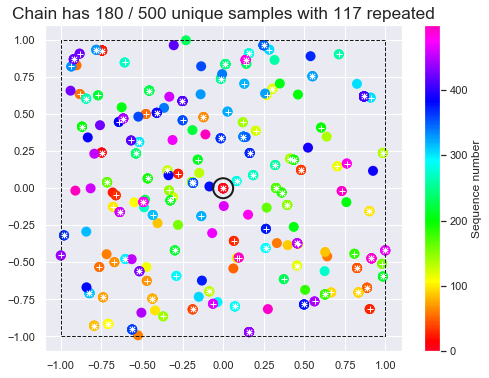

In [83]:
plot_square(MetropolisHastings(1., logP).run(500))

The last chain samples the target distribution well but has a lot of repeats. In contrast, this chain has no repeats but poorly samples $\tilde{P}$:

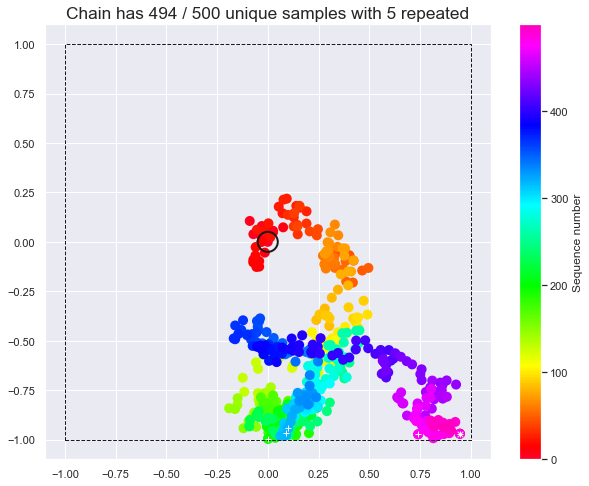

In [72]:
plot_square(MetropolisHastings(0.04, logP).run(500))

### Example: Line Fit with MCMC

Consider fitting a straight line $y = m x + b$, with parameters $m$ and $b$, to data with two features $x$ and $y$. The relevant log-likelihood function is:
$$
\log{\cal L}(m, b; D) = -\frac{N}{2}\log(2\pi\sigma_y^2)
-\frac{1}{2\sigma_y^2} \sum_{i=1}^N\, (y_i - m x_i - b)^2 \; ,
$$
where the error in $y$, $\sigma_y$, is a fixed hyperparameter. Note that the first term is the Gaussian PDF normalization factor.

First generate some data on a straight line with measurement errors in $y$ (so our assumed model is correct):

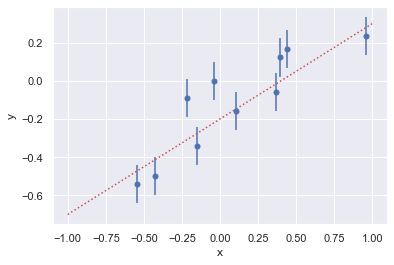

In [84]:
gen = np.random.RandomState(seed=123)
N, m_true, b_true, sigy_true = 10, 0.5, -0.2, 0.1
x_data = gen.uniform(-1, +1, size=N)
y_data = m_true * x_data + b_true + gen.normal(scale=sigy_true, size=N)

plt.errorbar(x_data, y_data, sigy_true, fmt='o', markersize=5)
plt.plot([-1, +1], [-m_true+b_true,+m_true+b_true], 'r:')
plt.xlabel('x'); plt.ylabel('y');

Next, define the log-likelihood function:

In [85]:
def loglike(x, y, m, b, sigy):
    N = len(x)
    norm = 0.5 * N * np.log(2 * np.pi * sigy ** 2)
    return -0.5 * np.sum((y - m * x - b) ** 2) / sigy ** 2 - norm

In [86]:
import functools
import inspect

import numpy as np
import pandas as pd

import emcee


def wrap(func, **kwargs):
    """Prepare an arbitrary function to use with emcee sampling.
    Emcee expects its parameters in a single list, but it is sometimes more
    convenient to write a function in terms of named parameters and
    hyperparameters. This method uses introspection to wrap an arbitrary
    function with named parameters so that it has the signature expected
    by emcee.
    For example:
        def f(x,y,a,b): ...
        wrap(f, x=[1], y=[2], a=3, b=4, c=3, d=4)
    returns a tuple (wrapped, ['x','y'], [1,2], {'c':3, 'd':4}) where:
      - wrapped([p,q]) calls f(x=p,y=q,a=3,b=4)
      - [1,2] are the initial values to use for parameters named ['x','y'].
      - {'c':3, 'd':4} are the input kwargs with args of f() removed.
    The square brackets identify floating arguments and specify their initial
    value. An optional callable to evaluate a log-prior can also be passed,
    for example:
        wrap(f, x=[1,px], y=[2,py], a=3, b=4, c=3, d=4)
    where px(x) and py(y) return the (un-normalized) log of the priors on
    x and y to use during posterior sampling.
    Parameters
    ----------
    func : callable
        The function that should be prepared. It is assumed to have only
        numerical arguments that accept any floating point values.
    **kwargs : keyword arguments
        All arguments of func must be included and assigned a value.
        Arguments assigned a floating point value are considered fixed
        during sampling.  Arguments assigned a floating point value
        within a list, e.g., [1.2], will be sampled using the initial
        value provided.  Sampled arguments can optionally also specify
        a log-prior distribution using, e.g. [1.2, lnprior], where lnprior
        is a function of the sampled argument that returns the log prior
        probability density (which does not need to be normalized).
    Returns
    -------
    tuple
        Tuple (wrapped, names, values, kwargs). See example above for details.
    """
    fixed = {}
    names, values, lnpriors = [], [], []
    funcsig = inspect.signature(func)
    try:
        funcargs = {name: kwargs[name] for name in funcsig.parameters}
    except KeyError:
        raise ValueError('Missing arguments.')
    bound = funcsig.bind(**funcargs)
    bound.apply_defaults()
    NoPrior = lambda x: 0.
    for name, value in bound.arguments.items():
        if isinstance(value, list):
            names.append(name)
            values.append(value.pop(0))
            lnpriors.append(value.pop(0) if value else NoPrior)
            if value:
                raise ValueError('Invalid syntax for argument {}.'.format(name))
        else:
            fixed[name] = value
    partial = functools.partial(func, **fixed)
    def wrapped(theta):
        if len(theta) != len(names):
            raise ValueError('expected list of {} values.'.format(len(names)))
        result = 0.
        for lnprior, value in zip(lnpriors, theta):
            result += lnprior(value)
            if not np.isfinite(result):
                # theta is not allowed by this prior.
                return -np.inf
        args = dict(zip(names, theta))
        result += partial(**args)
        return result
    # Remove function args from kwargs.
    for name in funcargs:
        kwargs.pop(name, None)
    return wrapped, names, values, kwargs


def sample(func, names, values, nwalkers=20, nsamples=1000, abs_rms=1e-4,
           frac_rms=1e-3, burnin=100, random_state=None):
    """Generate MCMC samples of the un-normalized PDF func() using emcee.
    Can be used standalone but intended to work with :func:`wrap`.
    Initial values for each walker are Gaussian samples centered on the
    input values with an RMS of max(abs_rms, frac_rms * values).
    Parameters
    ----------
    func : callable
        Evaluate the log PDF to sample. Passed a single list of parameter
        values. Can be prepared using :func:`wrap`.
    names : iterable
        List of names for each floating parameter.  Used to label columns
        in the returned DataFrame. Can be prepared using :func:`wrap`.
    values : iterable
        List of initial values for each floating parameter.  Used to center
        random initial values for each walker. Can be prepared using
        :func:`wrap`.
    nwalkers : int
        The number of emcee walkers to use.
    nsamples : int
        The total number of samples to return, after combining walkers
        and trimming initial burnin.
    abs_rms : float
        Used to set walker initial values.  See above for details.
    rel_rms : float
        Used to set walker initial values.  See above for details.
    burnin : int
        The number of samples to remove from each walker's chain.
    random_state : np.random.RandomState or None
        The random state to use for reproducible chains.
    Returns
    -------
    pandas.DataFrame
        Generated samples in a dataframe, using the inputs names for columns.
    """
    if random_state is None:
        random_state = np.random.RandomState()
    # Generate sampler starting points.
    ndim = len(names)
    values = np.array(values, float)
    initial = np.tile(values, (nwalkers, 1))
    rms = np.maximum(abs_rms, frac_rms * values)
    initial += rms * random_state.normal(size=(nwalkers, ndim))
    # Initialize and run sampler.
    sampler = emcee.EnsembleSampler(nwalkers, ndim, func)
    n_per_chain = 1 + nsamples // nwalkers + burnin
    sampler.run_mcmc(initial, n_per_chain, rstate0=random_state.get_state())
    # Remove burnin and return results in a DataFrame.
    chain = sampler.chain[:, burnin:].reshape(-1, ndim)[:nsamples]
    return pd.DataFrame(chain, columns=names)


def MCMC_sample(func, **kwargs):
    """Generate random samples from an un-normalized PDF.
    See :func:`wrap` and :func:`sample` for details.
    Parameters
    ----------
    func : callable
        Function to evaluate log(f(...)) where f(...) is proportional
        to the desired probability density.  Will be wrapped to
        determine which arguments are sampled and which are fixed.
    **kwargs : keyword arguments
        Used to configure the wrapping of func and the sampler.
    Returns
    -------
    pandas.DataFrame
        Generated samples in a dataframe, with one named column per
        sampled argument of the input function.
    """
    # Wrap the input function.
    wrapped, names, values, kwargs = wrap(func, **kwargs)
    # Generate emcee samples.
    return sample(wrapped, names, values, **kwargs)

Finally, generate some MCMC samples of the posterior $P(m, b\mid D, M)$ assuming uniform priors $P(b,m\mid \sigma_y) = 1$:

In [87]:
samples = MCMC_sample(loglike, m=[m_true], b=[b_true],
                      x=x_data, y=y_data, sigy=sigy_true,
                      nsamples=10000, random_state=gen)

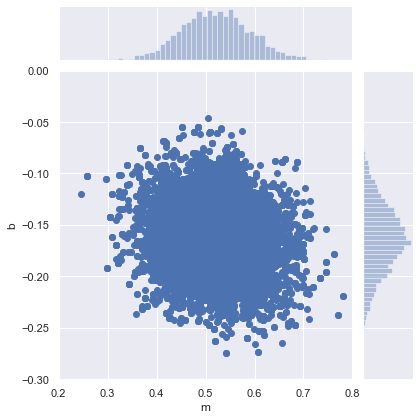

In [88]:
sns.jointplot('m', 'b', samples, xlim=(0.2,0.8), ylim=(-0.3,0.0), stat_func=None);

We always require a starting point to generate MCMC samples. In this example, we used the true parameter values as starting points:
```
m=[m_true], b=[b_true]
```
What happens if you chose different starting points?

In [89]:
samples2 = MCMC_sample(loglike, m=[m_true+0.1], b=[b_true+0.1],
                      x=x_data, y=y_data, sigy=sigy_true,
                       nsamples=10000, random_state=gen)

In [90]:
samples.describe(percentiles=[])

,m,b
count,10000.000000,10000.000000
mean,0.519848,-0.162424
std,0.071418,0.033693
min,0.246512,-0.274527
50%,0.519207,-0.162753
max,0.780647,-0.045919


In [91]:
samples2.describe(percentiles=[])

,m,b
count,10000.000000,10000.000000
mean,0.526590,-0.158687
std,0.075981,0.030783
min,0.278667,-0.273902
50%,0.522548,-0.158949
max,0.808847,-0.058641


The changes are small compared with the offsets ($\pm 0.1$) and the standard deviations in each parameter.

The inference above assumes flat priors for $m$ and $b$, but you can add any log-prior to our log-likelihood to change this.

For example, suppose our prior belief is that $0.4 \le m \le 0.7$:

In [92]:
def TopHat(lo, hi):
    """Return un-normalized log(prior) for x in [lo,hi]"""
    return lambda x: 0 if (lo <= x <= hi) else -np.inf

def Gauss(mu, sigma):
    """Return un-normalized log(prior) for x ~ N(mu,sigma)"""
    return lambda x: -0.5 * ((x - mu) / sigma) ** 2

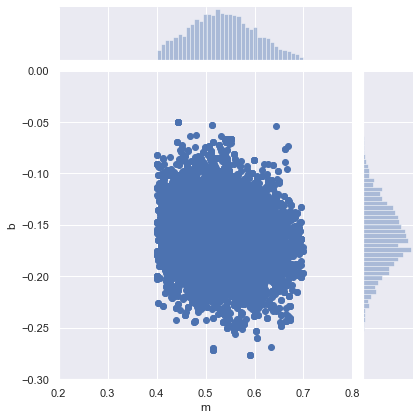

In [93]:
samples = MCMC_sample(loglike, m=[m_true,TopHat(0.4,0.7)], b=[b_true],
                      x=x_data, y=y_data, sigy=sigy_true,
                      nsamples=10000, random_state=gen)
sns.jointplot('m', 'b', samples, xlim=(0.2,0.8), ylim=(-0.3,0.0), stat_func=None);

Perhaps we also have a prior measurement that found $b = -0.20 \pm 0.02$ (in which case, the new data is not adding much information about $b$):

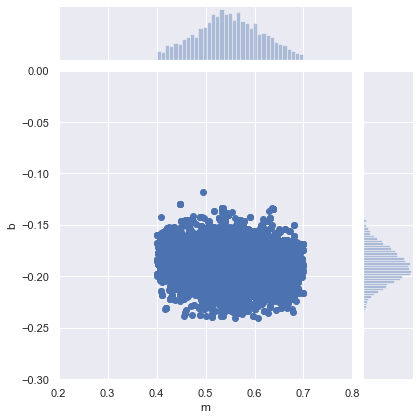

In [94]:
samples = MCMC_sample(loglike, m=[m_true,TopHat(0.4,0.7)],
                      b=[b_true,Gauss(-0.20,0.02)],
                      x=x_data, y=y_data, sigy=sigy_true,
                      nsamples=10000, random_state=gen)
sns.jointplot('m', 'b', samples, xlim=(0.2,0.8), ylim=(-0.3,0.0), stat_func=None);

### Practical Advice for MCMC

It is tempting to assume that MCMC samples have desirable properties beyond their minimum guarantees, since this is often true, but avoid this temptation.

In particular, MCMC samples are only guaranteed to sample your target $\tilde{P}(X_n)$ for $n$ sufficiently large. Therefore:
 - There is no way to know how big $n$ needs to be for a particular $\tilde{P}$.
   - **Burn-in?** Should I throw away the first $B$ samples to ensure that my chain is independent of its initial starting point?
   - **No:** There is no practical way to know how big $B$ should be. Instead, ensure that your starting point is reasonably probable (according to $\tilde{P}$) and use all samples. If you do not know how to chose a reasonably probably starting point, you need to solve a separate optimization problem before you are ready to use MCMC (which is notoriously inefficient at discovering new regions of high probability).
 - There are no useful guarantees about $\tilde{P}(X_n, X_m)$ and, in general, you should assume that the consecutive samples in any stretch of the chain are highly correlated.
   - **Thinning?** Should I just keep every $T$-th sample so that my chain is uncorrelated?
   - **No:** There is no practical way to know in advance how big $T$ should be, and you can never get a better answer (for a fixed amount of computation) by throwing away valid information. Just accept that samples are correlated.

How long should your chain be?

You should ideally use empirical measurements to determine $k$ such that the [autocorrelation](https://en.wikipedia.org/wiki/Autocorrelation)
$$
\frac{\langle (X_{n+k} - \mu) (X_n - \mu)\rangle}{\sigma^2} \simeq 0 \; ,
$$
where $\mu$ and $\sigma$ are the long-term mean and standard deviation of $\tilde{P}(X_n)$, then generate a chain whose length is at least 10-100 times this [autocorrelation](https://en.wikipedia.org/wiki/Autocorrelation) length $k$.

For Gibbs samplers, the Gelman & Rubin metric is also popular.

Which update rule should you use?
 - Determine which special cases apply to your target $\tilde{P}$, so you know which algorithms are possible.
   - Can you sample from a complete set of conditional distributions?  If so, add Gibbs sampling to your list.
   - Can you compute all partial derivatives? If so, add HMC to your list.
 - There is no "best" algorithm, so you will need to benchmark your problem against the available methods. 

Although it is instructive (and fun!) to implement simple update rules yourself, for serious work you should generally let someone else do the hard work for you by using an existing package.

Which package should you use?
 - For initial exploratory work, start with [emcee](http://dfm.io/emcee/), which implements [ensemble sampling](http://dx.doi.org/10.2140/camcos.2010.5.65) where many independent "walkers" simultaneously crawl around your target space, and has a nice [affine invariance](https://en.wikipedia.org/wiki/Affine_geometry) property, where the efficiency is not affected by any linear (aka "affine") transformation of your target space.
 - Look into [PyMC3](http://docs.pymc.io/notebooks/getting_started.html), [Edward](http://edwardlib.org/) (based on tensorflow) or [Pyro](http://docs.pyro.ai/en/0.2.1-release/index.html) (based on PyTorch) to explore HMC and other more advanced updating rules. These are generally more complex to use and have rigid rules for specifying your target $\tilde{P}$.
 - Consider an alternative approximate method for Bayesian inference, such as [variational inference](https://en.wikipedia.org/wiki/Variational_Bayesian_methods), with different tradeoffs.

## Method 4: Variational Inference

The essence of VI is to first define a family of PDFs that balance two competing criteria:
 - convenient for calculations, and
 - flexible enough to approximately match some unknown target PDF.

We then select the family member that is "closest" to the target.

In a Bayesian context, our target PDF is a posterior distribution, but VI is a more general technique for finding approximate PDFs.

Variational inference relies on a concept of "closeness" between two PDFs, which we call $q(\theta)$ and $p(\theta)$. Note that we are talking about "separation" in an abstract function space, rather than a coordinate space. Just as with coordinate separation, there are many possible valid definitions, e.g.
$$
(\sum_i (x_i - y_i)^2)^{1/2} \quad, \quad
\sum_i |x_i - y_i| \quad, \quad
\max_i\, |x_i - y_i| \quad, \ldots
$$

### Kullback-Leibler Divergence

VI traditionally uses the [Kullback Leibler (KL) divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence) to measure the "closeness" of PDFs $q(\theta)$ and $p(\theta)$:
$$
\boxed{
\text{KL}( q \parallel p ) \equiv \int d\theta\, q(\theta)\, \log\frac{q(\theta)}{p(\theta)}} \; .
$$

**DISCUSS:**
- Is KL divergence symmetric, $\text{KL}(q\parallel p) = \text{KL}(p\parallel q)$?
 - What is the value of $\text{KL}(q\parallel p)$ when $p = q$?
 - What happens to the integrand when either $q(\theta)$ or $p(\theta)$ approaches zero?
 - What bounds, if any, can you place on the value of $\text{KL}(q\parallel p)$ given that $p$ and $q$ are PDFs?

KL divergence is not symmetric since exchanging $q$ and $p$ in the integrand changes its value. This makes KL divergence an unusual measure of separation and means that it is not a true
[metric](https://en.wikipedia.org/wiki/Metric_%28mathematics%29).

When $p=q$, the log zeros the integrand (except possibly where $q$ has a singularity), resulting in a KL divergence of zero. This is what we would expect for a useful measure of separation.

When $q \rightarrow 0$ the combination $q \log q \rightarrow 0$. When $p(\theta)\rightarrow 0$, the log term diverges $\log(1/p)\rightarrow +\infty$. As a result, the KL integrand blows up wherever $\theta$ is very unlikely according to $p$, but doesn't care when $\theta$ is very unlikely according to $q$.

A PDF is always $\ge 0$ but not bounded from above, so the KL divergence is not bounded from above. However, nothing prevents $q(\theta) < p(\theta)$, so the integrand can be negative (due to the log) even with $p, q \ge 0$.

It turns out that the KL divergence is always $\ge 0$ but this is not obvious. The proof relies on the [log sum inequality](https://en.wikipedia.org/wiki/Log_sum_inequality), which in turns relies on [Jensen's inequality](https://en.wikipedia.org/wiki/Jensen's_inequality).

Since $q$ is a PDF, KL divergence can also be written as a difference of expectation values over $q$:
$$
\text{KL}( q \parallel p ) = \langle \log q(\theta)\rangle_q - \langle \log p(\theta)\rangle_q \; .
$$

This turns out to be very useful since it allows KL divergence to be numerically estimated using samples from $q$.

The KL divergence is a generic method to find the parameterized PDF $q(\theta,s)$ that "best" approximates some target PDF $p(\theta)$.

For Bayesian inference, the $p$ we care about is the posterior:
$$
p(\theta) = P(\theta\mid D) = \frac{P(D\mid \theta)\, P(\theta)}{P(D)} \; .
$$

Since we generally cannot calculate the evidence $P(D)$, a practical inference method should not require that we know its value.

The **variational Bayesian inference** method has three steps:
 - Define a family of PDFs $q(\theta; s)$ that approximate the true posterior $P(\theta\mid D)$.
 - Use optimization to find the value $s^\ast$ that, according to the KL divergence, best approximates the true posterior.
 - Use $q(\theta; s=s^\ast)$ as an approximation of the true posterior for calculating expectation values, etc.
 
The main tradeoff is in picking the approximate PDF family $q$.

A more flexible choice will generally do a better job of approximating the true posterior, but also require more difficult calculations.

Plugging the posterior into the KL definition, we can rewrite:
$$
\begin{aligned}
\text{KL}(q\parallel p) &= \int d\theta\, q(\theta) \log\left[
\frac{P(D)\, q(\theta)}{P(D\mid \theta)\, P(\theta)}
\right] \\
&= \int d\theta\, q(\theta) \left[\log P(D) +
\log\frac{q(\theta)}{P(\theta)} - \log P(D\mid\theta) \right] \\
&= \log P(D) + \text{KL}(q\parallel P(\theta)) - \int d\theta\, q(\theta) \log P(D\mid\theta) \; .
\end{aligned}
$$

The three terms on the right-hand side are:
 - The log of the evidence $P(D)$.
 - The KL divergence of $q(\theta)$ with respect to the prior $P(\theta)$.
 - The $q$-weighted log-likelihood of the data.

**DISCUSS:** Describe the $q(\theta)$ that would minimize the contribution of each term to their sum (assuming a fixed dataset $D$).

 - The log of the evidence is a constant offset in the sum, independent of $q$.
 - The KL divergence term is minimized when $q(\theta) = P(\theta)$, i.e., it drives $q$ to look like the prior.
 - The log-likelihood term is minimized when $q(\theta)$ prefers parameters $\theta$ that explain the data (since $q$ is normalized, it can only increase the weight of certain $\theta$ values by decreasing the weight of others). More formally, the last term is the [cross entropy](https://en.wikipedia.org/wiki/Cross_entropy) of $q(\theta)$ and $P(D\mid\theta)$, which is minimized when they are equal.

The competition between the last two terms is exactly what we need for a useful learning rule that balances prior knowledge with the information gained from new data.

We can solve the expression above for the (unknown) log-evidence as:
$$
\log P(D) = \int d\theta\, q(\theta) \log P(D\mid\theta) - \text{KL}(q\parallel P) + \text{KL}(q\parallel p) \; .
$$
Since the last term is $\ge 0$ (since any KL$\ge 0$), we find:
$$
\log P(D) \ge \int d\theta\, q(\theta) \log P(D\mid\theta) - \text{KL}(q\parallel P) \; ,
$$
and call this right-hand side the **evidence lower bound (ELBO)**:
$$
\begin{aligned}
\mathrm{ELBO}(q) &\equiv \int d\theta\, q(\theta) \log P(D\mid\theta) - \text{KL}(q\parallel P) \\
&= \int d\theta\, q(\theta) \log P(D\mid\theta) - \int d\theta\, q(\theta) \log\frac{q(\theta)}{P(\theta)} \\
&= \int d\theta\, q(\theta) \log \left[ P(D\mid\theta) P(\theta)\right]
- \int d\theta\, q(\theta) \log q(\theta) \; .
\end{aligned}
$$

Substituting above, we find that
$$
\text{KL}(q\parallel p) = \log P(D) - \text{ELBO}(q) \; ,
$$
so that the ELBO contains all of the $q$ dependence of the KL divergence of $q$ with respect to $p$.

The crucial insights are that:
 - Minimizing $-\text{ELBO}(q)$ with respect to $q$ is equivalent to minimizing $\text{KL}(q\parallel p)$.
 - $\text{ELBO}(q)$ does not depend on the evidence $P(D)$: **this property is what makes VI practical for Bayesian inference.**

Note that the ELBO can also be evaluated in terms of expectation values,
$$
\text{ELBO}(q) = \langle \log \left[ P(D\mid\theta) P(\theta)\right]\rangle_q - \langle \log q\rangle_q \; .
$$
The practical significance of this fact is that we can estimate the ELBO using averages of known quantities calculated with (finite) samples drawn from $q$, which effectively uses Monte Carlo integration with [importance sampling](https://en.wikipedia.org/wiki/Importance_sampling).

In [102]:
def calculate_KL(log_q, log_p, theta):
    """Calculate the KL divergence of q wrt p for single-parameter PDFs.
    Uses the trapezoid rule for the numerical integration. Integrals are only
    calculated over the input theta range, so are not valid when p or q have
    significant mass outside this range.
    Regions where either PDF is zero are handled correctly, although an
    integrable singularity due to p=0 will result in a divergent KL because the
    inputs are tabulated.
    Parameters
    ----------
    log_q : array
        Values of log q(theta, s) tabulated on a grid with shape (ns, ntheta)
        of s (axis=0) and theta (axis=1).
    log_p : array
        Values of log p(theta) tabulated on a grid with shape (ntheta) of theta.
    theta : array
        Values of theta where log_q and log_p are tabulated.
    Returns
    -------
    tuple
        Tuple (KL, integrand) where KL is an array of ns divergence values and
        integrand is an array with shape (ns, ntheta) of KL integrands.
    """
    # special handling for q=0.
    q_log_q = np.zeros_like(log_q)
    nonzero = log_q > -np.inf
    q_log_q[nonzero] = log_q[nonzero] * np.exp(log_q[nonzero])
    integrand = q_log_q - log_p * np.exp(log_q)
    return np.trapz(integrand, theta), integrand

def calculate_ELBO(log_q, log_likelihood, log_prior, theta):
    """Calculate the ELBO of q for single-parameter PDFs.
    """
    KLqP, integrand = calculate_KL(log_q, log_prior, theta)
    integrand = np.exp(log_q) * log_likelihood - integrand
    return np.trapz(integrand, theta), integrand


def plot_ELBO(q, q_scale_range, likelihood, prior, theta_range, n_data, seed=123):
    """Explanatory plots for the evidence lower bound (ELBO).
    Data is modeled with a single offset (loc) parameter theta with an arbitrary
    likelihood and prior. A random sample of generated data is used to calculate
    the posterior, which is approximated by adjusting the scale parameter of
    the arbitrary PDF family q.
    Parameters
    ----------
    q : str
        Name of a 1D continous random variable defined in scipy.stats.
    q_scale_range : list
        List [lo, hi] giving the range of scale factors to allow in defining the
        q family of PDFs.
    likelihood : str
        Name of a 1D continous random variable defined in scipy.stats.
    prior : str
        Name of a 1D continous random variable defined in scipy.stats.
    theta_range : list
        List [lo, hi] giving the range to use for plotting and integration.
        The true value of theta used to generate data is (lo + hi) / 2.
    n_data : int
        Number of data points to generate by sampling from the likelihood with
        theta = theta_true.
    seed : int
        Random number seed to use for reproducible results.
    """
    q = getattr(scipy.stats, q)
    likelihood = getattr(scipy.stats, likelihood)
    prior = getattr(scipy.stats, prior)

    # Generate random data using the midpoint of the theta range as the
    # true value of theta for sampling the likelihood.
    theta = np.linspace(*theta_range, 251)
    theta_true = 0.5 * (theta[0] + theta[-1])
    D = likelihood.rvs(
        loc=theta_true, size=n_data,
        random_state=np.random.RandomState(seed=seed))

    # Calculate the likelihood and prior for each theta.
    log_L = likelihood.logpdf(D, loc=theta[:, np.newaxis]).sum(axis=1)
    log_P = prior.logpdf(theta)

    # Calculate the evidence and posterior.
    log_post = log_L + log_P
    log_evidence = np.log(np.trapz(np.exp(log_post), theta))
    log_post -= log_evidence
    assert np.all(np.isfinite(log_post))

    q_scale = np.linspace(*q_scale_range, 101)
    log_q = q.logpdf(theta, scale=q_scale[:, np.newaxis])

    KLs, KL_ints = calculate_KL(log_q, log_post, theta)
    ibest = np.argmin(KLs)

    ELBOs, ELBO_ints = calculate_ELBO(log_q, log_L, log_P, theta)

    fig = plt.figure(figsize=(12, 8))
    ax = [plt.subplot2grid((2,2), (0,0)), plt.subplot2grid((2,2), (1,0)),
          plt.subplot2grid((2,2), (0,1)), plt.subplot2grid((2,2), (1,1))]
    cmap = sns.color_palette('bright', n_colors=1 + len(KLs)).as_hex()

    ax[0].plot(theta, np.exp(log_post), '-', lw=10, c=cmap[0],
               alpha=0.25, label='$P(\\theta\mid D)$')
    ax[0].axhline(0., color='gray', lw=1)
    ax[1].axhline(0., color='gray', lw=1)
    ax[2].axhline(0., color='gray', lw=1)
    ax[2].plot(q_scale, KLs, 'k-', label='KL$(q(s) \parallel p)$')
    ax[2].plot(q_scale, log_evidence - ELBOs, 'k:', lw=6,
               alpha=0.5, label='$\log P(D) - ELBO(q(s))$')
    for i, idx in enumerate((0, ibest, -1)):
        c = cmap[i + 1]
        label = '$q(\\theta;s={:.2f})$'.format(q_scale[idx])
        ax[0].plot(theta, np.exp(log_q[idx]), '--', lw=2,
                   alpha=1, c=c, label=label)
        ax[1].plot(theta, KL_ints[idx], '--', lw=2, alpha=1, c=c)
        ax[2].scatter(q_scale[idx], KLs[idx], lw=0, c=c, s=150)
    ax[0].legend()
    ax[0].set_ylabel('$p(x), q(\\theta; s)$', fontsize='x-large')
    ax[0].set_xlim(*theta_range)
    ax[0].set_xlabel('Model parameter $\\theta$', fontsize='large')
    ax[0].set_yticks([])
    ax[1].set_ylabel('KL$(q \parallel p)$ integrand', fontsize='x-large')
    ax[1].set_xlim(*theta_range)
    ax[1].set_xlabel('Model parameter $\\theta$', fontsize='large')
    ax[1].set_yticks([])
    ax[2].set_xlabel('$q(\\theta;s)$ scale $s$', fontsize='large')
    ax[2].legend(loc='upper center', fontsize='x-large')

    x_lim = 1.1 * np.max(np.abs(D))
    ax[3].hist(D, density=True, range=(-x_lim, +x_lim), histtype='stepfilled')
    x = np.linspace(-x_lim, +x_lim, 250)
    dtheta = 0.25 * (theta[-1] - theta[0])
    for theta, ls in zip(
        (theta_true - dtheta, theta_true, theta_true + dtheta),
        ('--', '-', ':')):
        label = '$P(x\mid \\theta={:+.2f})$'.format(theta)
        ax[3].plot(x, likelihood.pdf(x, loc=theta), 'k', ls=ls, label=label)
    ax[3].set_xlabel('Observed sample $x$')
    ax[3].set_xlim(-x_lim, +x_lim)
    ax[3].legend()

    plt.subplots_adjust(
        left=0.05, right=0.95, hspace=0.25, wspace=0.15, top=0.95)
    fig.suptitle(
        '$\\theta_{\\mathrm{true}}' + ' = {:.2f}$ , $\log P(D) = {:.1f}$'
        .format(theta_true, log_evidence), fontsize='large')

### Example

Suppose we observe 1D data $x$ that we model with an exponential (aka [Laplacian](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.laplace.html)) likelihood and one unknown location parameter $\theta$:
$$
P(x\mid \theta) = \frac{1}{2}\, e^{-|x - \theta|} \; .
$$

The resulting likelihood for observations $D = \{x_i\}$ is:
$$
P(D\mid\theta) = \prod_i P(x_i\mid\theta) \; ,
$$

The corresponding posterior
$$
P(\theta\mid D) = \frac{P(D\mid\theta)\, P(\theta)}{P(D)}
$$
is not a simple distribution since it depends on the random data $D$ and reflects its statistical fluctuations. 

However, it is roughly Gaussian, so we use a family $q$ of Gaussians to approximate it, which have $\mu=0$ fixed and $s = \sigma$ varying.

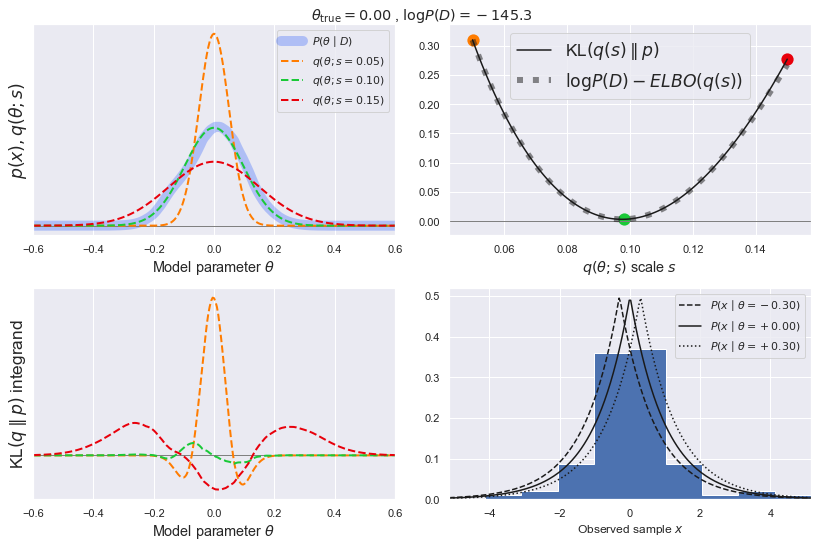

In [104]:
plot_ELBO(q='norm', q_scale_range=[0.05, 0.15],
          likelihood='laplace', prior='norm',
          theta_range=[-0.6, +0.6], n_data=100)

## Unified Treatment with KL Divergence